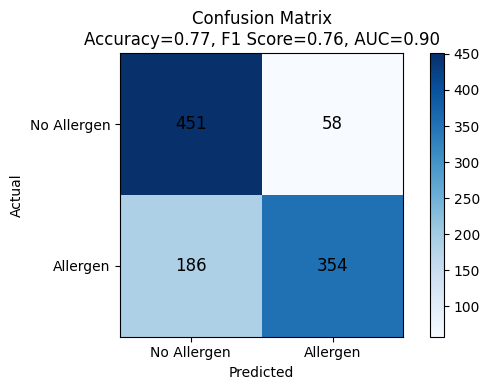

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, array_intersect, size, when, lit, transform, rand
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# Start Spark Session
spark = SparkSession.builder.appName("Allergen Detection with Undersampling").getOrCreate()

# Load JSON file
data = spark.read.option("multiline", "true").json("/content/test.json")

# Define allergens (expanded terms)
allergens = [
    'milk', 'eggs', 'egg yolks', 'egg whites', 'peanuts', 'almonds', 'pecans', 'walnuts',
    'soy', 'soybeans', 'wheat', 'gluten', 'fish', 'shrimp', 'crab', 'lobster', 'shellfish',
    'cheese', 'parmesan', 'parmigiano', 'cheddar', 'mozzarella', 'butter', 'cream', 'yogurt'
]

# Normalize ingredient list
data = data.withColumn("ingredient_array", transform(col("ingredients"), lambda x: lower(x)))

# Mark allergen presence
data = data.withColumn(
    "Has_Allergen",
    when(size(array_intersect(col("ingredient_array"), lit(allergens))) > 0, 1).otherwise(0)
)

# Check class counts
counts = data.groupBy("Has_Allergen").count()
counts.show()

# --- UNDERSAMPLING TO BALANCE CLASSES ---
# Separate the classes
minority_df = data.filter(col("Has_Allergen") == 1)
majority_df = data.filter(col("Has_Allergen") == 0)

# Undersample majority class to match minority size
minority_count = minority_df.count()
majority_downsampled = majority_df.orderBy(rand()).limit(minority_count)

# Combine both for balanced dataset
balanced_data = majority_downsampled.union(minority_df)

# -------- TF-IDF Feature Transformation --------
tf = HashingTF(inputCol="ingredient_array", outputCol="rawFeatures", numFeatures=5000)
tf_data = tf.transform(balanced_data)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(tf_data)
tfidf_data = idf_model.transform(tf_data)

# Select final columns
final_data = tfidf_data.select("features", "Has_Allergen")

# Train-test split
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# -------- Train RandomForest --------
rf = RandomForestClassifier(labelCol="Has_Allergen", featuresCol="features", numTrees=100, seed=42)
rf_model = rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# -------- Evaluation Metrics --------
auc = BinaryClassificationEvaluator(labelCol="Has_Allergen", metricName="areaUnderROC").evaluate(predictions)
accuracy = MulticlassClassificationEvaluator(labelCol="Has_Allergen", metricName="accuracy").evaluate(predictions)
f1_score = MulticlassClassificationEvaluator(labelCol="Has_Allergen", metricName="f1").evaluate(predictions)

# Confusion matrix
predictions_pd = predictions.select("Has_Allergen", "prediction").toPandas()
conf_matrix = pd.crosstab(predictions_pd["Has_Allergen"], predictions_pd["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Ensure full matrix
for val in [0.0, 1.0]:
    if val not in conf_matrix.index:
        conf_matrix.loc[val] = 0
    if val not in conf_matrix.columns:
        conf_matrix[val] = 0
conf_matrix = conf_matrix.sort_index().sort_index(axis=1)

# -------- Plot Confusion Matrix --------
plt.figure(figsize=(6, 4))
plt.title(f"Confusion Matrix\nAccuracy={accuracy:.2f}, F1 Score={f1_score:.2f}, AUC={auc:.2f}")
ax = plt.gca()
heatmap = plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
plt.colorbar(heatmap)
plt.xticks([0, 1], ["No Allergen", "Allergen"])
plt.yticks([0, 1], ["No Allergen", "Allergen"])
for i in range(2):
    for j in range(2):
        value = conf_matrix.iloc[i, j]
        ax.text(j, i, int(value), ha="center", va="center", color="black", fontsize=12)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


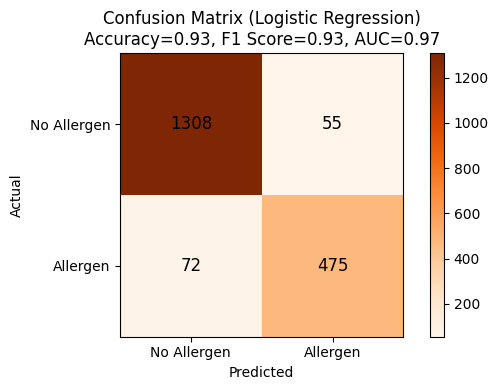

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, array_intersect, size, when, lit, transform
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# Start Spark Session
spark = SparkSession.builder.appName("Allergen Detection - Logistic Regression").getOrCreate()

# Load JSON file
data = spark.read.option("multiline", "true").json("/content/test.json")

# Define expanded allergen terms
allergens = [
    'milk', 'eggs', 'egg yolks', 'egg whites', 'peanuts', 'almonds', 'pecans', 'walnuts',
    'soy', 'soybeans', 'wheat', 'gluten', 'fish', 'shrimp', 'crab', 'lobster', 'shellfish',
    'cheese', 'parmesan', 'parmigiano', 'cheddar', 'mozzarella', 'butter', 'cream', 'yogurt'
]

# Lowercase ingredients
data = data.withColumn("ingredient_array", transform(col("ingredients"), lambda x: lower(x)))

# Allergen label
data = data.withColumn(
    "Has_Allergen",
    when(size(array_intersect(col("ingredient_array"), lit(allergens))) > 0, 1).otherwise(0)
)

# Check class imbalance
class_counts = data.groupBy("Has_Allergen").count().toPandas()
majority_class = class_counts['count'].max()
class_weights = {row['Has_Allergen']: majority_class / row['count'] for _, row in class_counts.iterrows()}

# Add weights column
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
get_weight = udf(lambda label: float(class_weights[label]), DoubleType())
data = data.withColumn("classWeightCol", get_weight(col("Has_Allergen")))

# TF-IDF
tf = HashingTF(inputCol="ingredient_array", outputCol="rawFeatures", numFeatures=5000)
tf_data = tf.transform(data)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(tf_data)
tfidf_data = idf_model.transform(tf_data)

# Select data
final_data = tfidf_data.select("features", "Has_Allergen", "classWeightCol")
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression with class weights
lr = LogisticRegression(
    labelCol="Has_Allergen",
    featuresCol="features",
    weightCol="classWeightCol",
    maxIter=100
)
lr_model = lr.fit(train_data)

# Predict
predictions = lr_model.transform(test_data)

# Evaluate
auc = BinaryClassificationEvaluator(labelCol="Has_Allergen", metricName="areaUnderROC").evaluate(predictions)
accuracy = MulticlassClassificationEvaluator(labelCol="Has_Allergen", metricName="accuracy").evaluate(predictions)
f1_score = MulticlassClassificationEvaluator(labelCol="Has_Allergen", metricName="f1").evaluate(predictions)

# Confusion matrix
predictions_pd = predictions.select("Has_Allergen", "prediction").toPandas()
conf_matrix = pd.crosstab(predictions_pd["Has_Allergen"], predictions_pd["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Ensure 0/1 are present in matrix
for val in [0.0, 1.0]:
    if val not in conf_matrix.index:
        conf_matrix.loc[val] = 0
    if val not in conf_matrix.columns:
        conf_matrix[val] = 0
conf_matrix = conf_matrix.sort_index().sort_index(axis=1)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.title(f"Confusion Matrix (Logistic Regression)\nAccuracy={accuracy:.2f}, F1 Score={f1_score:.2f}, AUC={auc:.2f}")
ax = plt.gca()
heatmap = plt.imshow(conf_matrix, cmap="Oranges", interpolation="nearest")
plt.colorbar(heatmap)
plt.xticks([0, 1], ["No Allergen", "Allergen"])
plt.yticks([0, 1], ["No Allergen", "Allergen"])
for i in range(2):
    for j in range(2):
        value = conf_matrix.iloc[i, j]
        ax.text(j, i, int(value), ha="center", va="center", color="black", fontsize=12)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


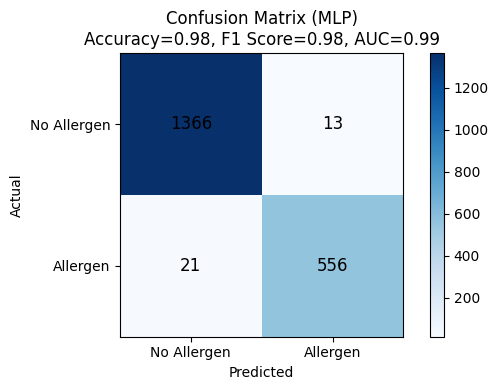

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, array_intersect, size, when, lit, transform
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# Start Spark Session
spark = SparkSession.builder.appName("Allergen Detection - MLP Classifier").getOrCreate()

# Load JSON data
data = spark.read.option("multiline", "true").json("/content/test.json")

# Allergen keywords
allergens = [
    'milk', 'eggs', 'egg yolks', 'egg whites', 'peanuts', 'almonds', 'pecans', 'walnuts',
    'soy', 'soybeans', 'wheat', 'gluten', 'fish', 'shrimp', 'crab', 'lobster', 'shellfish',
    'cheese', 'parmesan', 'parmigiano', 'cheddar', 'mozzarella', 'butter', 'cream', 'yogurt'
]

# Process ingredients
data = data.withColumn("ingredient_array", transform(col("ingredients"), lambda x: lower(x)))
data = data.withColumn("Has_Allergen", when(size(array_intersect(col("ingredient_array"), lit(allergens))) > 0, 1).otherwise(0))

# TF-IDF features
tf = HashingTF(inputCol="ingredient_array", outputCol="rawFeatures", numFeatures=5000)
tf_data = tf.transform(data)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(tf_data)
tfidf_data = idf_model.transform(tf_data)

# Final data
final_data = tfidf_data.select("features", "Has_Allergen")
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=100)

# Define MLP layers: input -> hidden -> output
# input layer: 5000 (same as HashingTF numFeatures)
# hidden layers: can adjust size, e.g. [64, 32]
# output layer: 2 classes
layers = [5000, 64, 32, 2]

# Train MLP
mlp = MultilayerPerceptronClassifier(
    labelCol="Has_Allergen",
    featuresCol="features",
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=42
)
mlp_model = mlp.fit(train_data)
predictions = mlp_model.transform(test_data)

# Evaluate
auc = BinaryClassificationEvaluator(labelCol="Has_Allergen", metricName="areaUnderROC").evaluate(predictions)
accuracy = MulticlassClassificationEvaluator(labelCol="Has_Allergen", metricName="accuracy").evaluate(predictions)
f1_score = MulticlassClassificationEvaluator(labelCol="Has_Allergen", metricName="f1").evaluate(predictions)

# Confusion matrix
predictions_pd = predictions.select("Has_Allergen", "prediction").toPandas()
conf_matrix = pd.crosstab(predictions_pd["Has_Allergen"], predictions_pd["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Fill in any missing rows/cols (0 or 1)
for val in [0.0, 1.0]:
    if val not in conf_matrix.index:
        conf_matrix.loc[val] = 0
    if val not in conf_matrix.columns:
        conf_matrix[val] = 0
conf_matrix = conf_matrix.sort_index().sort_index(axis=1)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.title(f"Confusion Matrix (MLP)\nAccuracy={accuracy:.2f}, F1 Score={f1_score:.2f}, AUC={auc:.2f}")
ax = plt.gca()
heatmap = plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
plt.colorbar(heatmap)
plt.xticks([0, 1], ["No Allergen", "Allergen"])
plt.yticks([0, 1], ["No Allergen", "Allergen"])
for i in range(2):
    for j in range(2):
        value = conf_matrix.iloc[i, j]
        ax.text(j, i, int(value), ha="center", va="center", color="black", fontsize=12)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Extract true and predicted labels
y_true = predictions_pd["Has_Allergen"]
y_pred = predictions_pd["prediction"]

# Generate and print classification report
report = classification_report(y_true, y_pred, target_names=["No Allergen", "Allergen"])
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

 No Allergen       0.98      0.99      0.99      1379
    Allergen       0.98      0.96      0.97       577

    accuracy                           0.98      1956
   macro avg       0.98      0.98      0.98      1956
weighted avg       0.98      0.98      0.98      1956



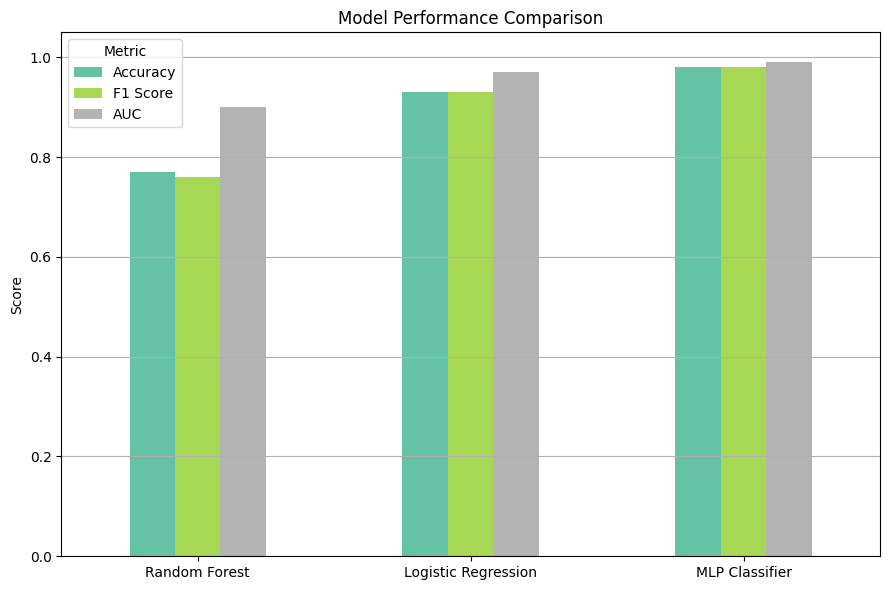

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Manually input the performance scores from your runs
model_scores = {
    "Random Forest": {"Accuracy": 0.77, "F1 Score": 0.76, "AUC": 0.90},
    "Logistic Regression": {"Accuracy": 0.93, "F1 Score": 0.93, "AUC": 0.97},
    "MLP Classifier": {"Accuracy": 0.98, "F1 Score": 0.98, "AUC": 0.99}
}

# Convert to DataFrame
df_scores = pd.DataFrame(model_scores).T

# Plot side-by-side comparison
ax = df_scores.plot(kind="bar", figsize=(9, 6), rot=0, colormap="Set2")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lower, transform, array, lit,
    when, size, array_intersect
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StopWordsRemover, NGram,
    HashingTF, IDF, StringIndexer, IndexToString
)
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Spark session
spark = SparkSession.builder.appName("Allergen Multiclass MLP").getOrCreate()

# 2. Load & lowercase
df0 = spark.read.option("multiline","true").json("/content/test.json")
df1 = df0.withColumn(
    "ingredient_array",
    transform(col("ingredients"), lambda x: lower(x))
)

# 3. Build keyword arrays
dairy_kw  = array(*[lit(i) for i in ['milk','cheese','parmesan','butter','cream','yogurt']])
nuts_kw   = array(*[lit(i) for i in ['peanuts','almonds','pecans','walnuts']])
shell_kw  = array(*[lit(i) for i in ['shrimp','crab','lobster','shellfish']])
gluten_kw = array(*[lit(i) for i in ['wheat','gluten','flour']])

# 4. Pure-DF label assignment
df2 = df1.withColumn(
    "category",
    when(size(array_intersect(col("ingredient_array"), dairy_kw)) > 0, "dairy")
    .when(size(array_intersect(col("ingredient_array"), nuts_kw)) > 0, "nuts")
    .when(size(array_intersect(col("ingredient_array"), shell_kw)) > 0, "shellfish")
    .when(size(array_intersect(col("ingredient_array"), gluten_kw)) > 0, "gluten")
    .otherwise("none")
)

# 5. Pipeline stages (no Tokenizer)
remover       = StopWordsRemover(inputCol="ingredient_array", outputCol="words")
ngrams        = NGram(n=2, inputCol="words", outputCol="bigrams")
hashTF        = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=5000)
idf           = IDF(inputCol="rawFeatures", outputCol="features")
label_indexer = StringIndexer(inputCol="category", outputCol="label")

# 6. MLP
num_classes = df2.select("category").distinct().count()
layers      = [5000, 128, 64, num_classes]
mlp         = MultilayerPerceptronClassifier(
                  featuresCol="features", labelCol="label",
                  layers=layers, maxIter=50, blockSize=128, seed=42
              )

# 7. Predicted-label → string
label_lookup = IndexToString(
                   inputCol="prediction", outputCol="predicted_category",
                   labels=label_indexer.fit(df2).labels
               )

pipeline = Pipeline(stages=[
    remover, ngrams, hashTF, idf,
    label_indexer, mlp, label_lookup
])

# 8. Train/test & fit
train, test = df2.randomSplit([0.8, 0.2], seed=100)
model       = pipeline.fit(train)

# 9. Evaluate
preds = model.transform(test)
acc   = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(preds)
f1    = MulticlassClassificationEvaluator(metricName="f1").evaluate(preds)
print(f"Accuracy={acc:.3f}, F1={f1:.3f}")

# 10. Inspect & save
preds.select("ingredients","category","predicted_category").show(10, truncate=False)
model.write().overwrite().save("/content/allergen_mlp_multiclass_pipeline")


Accuracy=0.745, F1=0.741
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+------------------+
|ingredients                                                                                                                                                                                                                                          |category|predicted_category|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+------------------+
|[sugar, vanilla extract, corn starch, coffee granules, salt, vanilla low-fat frozen yogurt, brewed coffee, corn syrup, large egg whites, Dutch-pro

Multi‐class Accuracy = 0.966
Multi‐class F1 Score  = 0.966


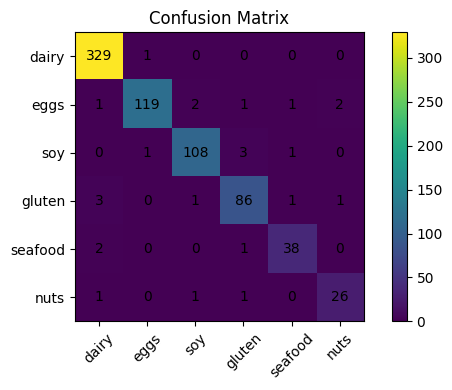

              precision    recall  f1-score   support

       dairy       0.98      1.00      0.99       330
        eggs       0.98      0.94      0.96       126
         soy       0.96      0.96      0.96       113
      gluten       0.93      0.93      0.93        92
     seafood       0.93      0.93      0.93        41
        nuts       0.90      0.90      0.90        29

    accuracy                           0.97       731
   macro avg       0.95      0.94      0.94       731
weighted avg       0.97      0.97      0.97       731



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, transform, udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import HashingTF, IDF, StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1. Start Spark session
spark = SparkSession.builder.appName("Allergen Detection - MultiClass MLP").getOrCreate()

# 2. Load data
data = spark.read.option("multiline", "true").json("/content/test.json")

# 3. Define allergen‑to‑category mapping
allergen_categories = {
    'dairy': ['milk','cheese','butter','cream','yogurt',
              'parmigiano','parmesan','mozzarella','cheddar'],
    'eggs': ['eggs','egg yolks','egg whites'],
    'nuts': ['peanuts','almonds','pecans','walnuts'],
    'seafood': ['fish','shrimp','crab','lobster','shellfish'],
    'gluten': ['wheat','gluten','all-purpose flour'],
    'soy': ['soy','soybeans','tofu','soy sauce']
}

# 4. UDF to assign category (first match wins)
def get_category(ings):
    for cat, keywords in allergen_categories.items():
        for ing in ings:
            if ing in keywords:
                return cat
    return 'none'

get_cat_udf = udf(get_category, StringType())

# 5. Lowercase ingredients, assign categories, filter out 'none'
processed = (
    data
    .withColumn("ingredient_array", transform(col("ingredients"), lambda x: lower(x)))
    .withColumn("AllergenCategory", get_cat_udf(col("ingredient_array")))
    .filter(col("AllergenCategory") != 'none')
)

# 6. Split into train/test
train_df, test_df = processed.randomSplit([0.8, 0.2], seed=42)

# 7. Build ML Pipeline
hashingTF = HashingTF(inputCol="ingredient_array", outputCol="rawFeatures", numFeatures=5000)
idf       = IDF(inputCol="rawFeatures", outputCol="features")
indexer  = StringIndexer(inputCol="AllergenCategory", outputCol="label")  # will be fitted
# We'll fit the indexer on the training data to get label list
label_indexer_model = indexer.fit(train_df)
num_classes = len(label_indexer_model.labels)

# Define MLP layers: input 5000 → hidden [64,32] → output num_classes
layers = [5000, 64, 32, num_classes]

mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    layers=layers,
    maxIter=100,
    blockSize=128,
    seed=42
)

pipeline = Pipeline(stages=[hashingTF, idf, label_indexer_model, mlp])

# 8. Train
model = pipeline.fit(train_df)

# 9. Predict
predictions = model.transform(test_df)

# 10. Evaluate
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")

accuracy = evaluator_acc.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Multi‐class Accuracy = {accuracy:.3f}")
print(f"Multi‐class F1 Score  = {f1_score:.3f}")

# 11. Confusion matrix & classification report
pred_pd = predictions.select("label", "prediction").toPandas()
conf_matrix = pd.crosstab(pred_pd["label"], pred_pd["prediction"],
                          rownames=["Actual"], colnames=["Predicted"],
                          dropna=False)

# Plot it
plt.figure(figsize=(6,4))
plt.imshow(conf_matrix, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(num_classes), label_indexer_model.labels, rotation=45)
plt.yticks(range(num_classes), label_indexer_model.labels)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, conf_matrix.iloc[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# Classification report
y_true = pred_pd["label"]
y_pred = pred_pd["prediction"]
print(classification_report(y_true, y_pred, target_names=label_indexer_model.labels))


In [ ]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

# 1) Start Spark session
spark = SparkSession.builder.appName("Allergen Multi‑Label MLP + CV").getOrCreate()

# 2) Load JSON and lowercase ingredients
data = spark.read.option("multiline", "true").json("/content/test.json")
data = data.withColumn(
    "ingredient_array",
    F.expr("transform(ingredients, x -> lower(x))")
)

# 3) Create one-hot labels for each allergen category
allergen_categories = {
    "dairy":   ["milk","cheese","butter","cream","yogurt","parmesan","parmigiano","mozzarella","cheddar"],
    "eggs":    ["eggs","egg yolks","egg whites"],
    "nuts":    ["peanuts","almonds","pecans","walnuts"],
    "seafood": ["fish","shrimp","crab","lobster","shellfish"],
    "gluten":  ["wheat","gluten","all-purpose flour"],
    "soy":     ["soy","soybeans","tofu","soy sauce"]
}
for cat, kws in allergen_categories.items():
    data = data.withColumn(
        f"is_{cat}",
        F.when(
            F.size(
                F.array_intersect(
                    F.col("ingredient_array"),
                    F.array(*[F.lit(k) for k in kws])
                )
            ) > 0,
            1
        ).otherwise(0)
    )

# 4) Split into train/test
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

# 5) Define shared featurization stages
hashingTF = HashingTF(inputCol="ingredient_array", outputCol="rawFeatures")
idf       = IDF(inputCol="rawFeatures", outputCol="features")

# 6) Prepare the MLP instance
mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", seed=42)

# 7) Manually build a list of ParamMaps so that numFeatures always matches the MLP input size
paramMaps = []
for numF in [2000, 5000]:
    # only use layer-configs whose first element equals numF
    layers_opts = {
        2000: [[2000, 64, 2]],
        5000: [[5000, 64, 2], [5000, 128, 64, 2]]
    }[numF]
    for minDf in [0, 2]:
        for maxIter in [50, 100]:
            for layers in layers_opts:
                paramMaps.append({
                    hashingTF.numFeatures: numF,
                    idf.minDocFreq:       minDf,
                    mlp.maxIter:          maxIter,
                    mlp.layers:           layers
                })

# 8) Evaluators
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
accuracy_eval    = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

# 9) Build pipeline and CrossValidator (reused per category)
pipeline = Pipeline(stages=[hashingTF, idf, mlp])
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramMaps,
    evaluator=binary_evaluator,
    numFolds=3
)

# 10) Loop over each allergen, train, and evaluate
results = {}
for cat in allergen_categories:
    print(f"\n=== Training & tuning for '{cat}' ===")
    train = train_df.select("ingredient_array", F.col(f"is_{cat}").alias("label"))
    test  = test_df .select("ingredient_array", F.col(f"is_{cat}").alias("label"))

    cvModel   = cv.fit(train)            # runs 3‑fold CV
    bestModel = cvModel.bestModel        # PipelineModel with best params

    pred = bestModel.transform(test)
    roc  = binary_evaluator.evaluate(pred)
    acc  = accuracy_eval.evaluate(pred)

    print(f"{cat:8s} → AUC = {roc:.3f},  Accuracy = {acc:.3f}")
    results[cat] = {"AUC": roc, "Accuracy": acc}

print("\nAll results:", results)



=== Training & tuning for 'dairy' ===
dairy    → AUC = 0.998,  Accuracy = 0.994

=== Training & tuning for 'eggs' ===
eggs     → AUC = 1.000,  Accuracy = 0.999

=== Training & tuning for 'nuts' ===
nuts     → AUC = 0.995,  Accuracy = 0.988

=== Training & tuning for 'seafood' ===
seafood  → AUC = 0.990,  Accuracy = 0.996

=== Training & tuning for 'gluten' ===
gluten   → AUC = 1.000,  Accuracy = 1.000

=== Training & tuning for 'soy' ===
soy      → AUC = 0.999,  Accuracy = 0.999

All results: {'dairy': {'AUC': 0.9981544811320755, 'Accuracy': 0.993717277486911}, 'eggs': {'AUC': 0.9999971871316901, 'Accuracy': 0.9994764397905759}, 'nuts': {'AUC': 0.9947374912634133, 'Accuracy': 0.9884816753926702}, 'seafood': {'AUC': 0.9904164740329784, 'Accuracy': 0.9958115183246073}, 'gluten': {'AUC': 1.0, 'Accuracy': 1.0}, 'soy': {'AUC': 0.999336595392214, 'Accuracy': 0.9989528795811519}}
